In [ ]:
#@title Dependencies Installation
%pip install openai_clip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
  Created wheel for openai_clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=0d3f86eb893bbb4d9d97a455d078ce633dc58f9e96e56a672076eea62afa1b43
  Stored in directory: /root/.cache/pip/wheels/0d/17/90/042948fd2e2a87f1dcf6db6d438cad015c49db0c53d1d9c7dc
Successfully built openai_clip


In [ ]:
#@title Imports
import torch
import torchvision
import clip
from tqdm import tqdm
import os
import gc
from torchvision import transforms
from google.colab import userdata
import google.generativeai as genai
from pydantic import BaseModel, Field
from typing import List, Dict, Any
import json
from torchvision.datasets import Flowers102 as datset_used


CLASS_NAMES = ["pink primrose", "hard-leaved pocket orchid", "canterbury bells", "sweet pea", "english marigold", "tiger lily", "moon orchid", "bird of paradise", "monkshood", "globe thistle", "snapdragon", "colt's foot", "king protea", "spear thistle", "yellow iris", "globe-flower", "purple coneflower", "peruvian lily", "balloon flower", "giant white arum lily", "fire lily", "pincushion flower", "fritillary", "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers", "stemless gentian", "artichoke", "sweet william", "carnation", "garden phlox", "love in the mist", "mexican aster", "alpine sea holly", "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip", "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia", "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy", "common dandelion", "petunia", "wild pansy", "primula", "sunflower", "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia", "pink-yellow dahlia?", "cautleya spicata", "japanese anemone", "black-eyed susan", "silverbush", "californian poppy", "osteospermum", "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania", "azalea", "water lily", "rose", "thorn apple", "morning glory", "passion flower", "lotus", "toad lily", "anthurium", "frangipani", "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow", "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum", "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow", "mexican petunia", "bromelia", "blanket flower", "trumpet creeper", "blackberry lily"]

# Custum pre generated prompts
!wget https://raw.githubusercontent.com/matteogrisenti/CLIP-zero-shot/main/generated_prompts.json

--2025-07-21 08:32:49--  https://raw.githubusercontent.com/matteogrisenti/CLIP-zero-shot/main/generated_prompts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46539 (45K) [text/plain]
Saving to: ‘generated_prompts.json’

generated_prompts.j 100%[===================>]  45.45K  --.-KB/s    in 0.007s  

2025-07-21 08:32:49 (6.63 MB/s) - ‘generated_prompts.json’ saved [46539/46539]



In [ ]:
#@title Clip Utils functions

def get_data(data_dir="./data", transform=None):
    """Load Flowers102 train, validation and test sets.
    Args:
        data_dir (str): Directory where the dataset will be stored.
        transform (torch.Compose)
    Returns:
        tuple: A tuple containing the train, validation, and test sets.
    """
    train = datset_used(root=data_dir, split="train", download=True, transform=transform)
    val = datset_used(root=data_dir, split="val", download=True, transform=transform)
    test = datset_used(root=data_dir, split="test", download=True, transform=transform)
    return train, val, test

def base_novel_categories(dataset):
    # set returns the unique set of all dataset classes
    all_classes = set(dataset._labels)
    # and let's count them
    num_classes = len(all_classes)

    # here list(range(num_classes)) returns a list from 0 to num_classes - 1
    # then we slice the list in half and generate base and novel category lists
    base_classes = list(range(num_classes))[:num_classes//2]
    novel_classes = list(range(num_classes))[num_classes//2:]
    return base_classes, novel_classes

def split_data(dataset, base_classes):
    # these two lists will store the sample indexes
    base_categories_samples = []
    novel_categories_samples = []

    # we create a set of base classes to compute the test below in O(1)
    # this is optional and can be removed
    base_set = set(base_classes)

    # here we iterate over sample labels and also get the correspondent sample index
    for sample_id, label in enumerate(dataset._labels):
        if label in base_set:
            base_categories_samples.append(sample_id)
        else:
            novel_categories_samples.append(sample_id)

    # here we create the dataset subsets
    # the torch Subset is just a wrapper around the dataset
    # it simply stores the subset indexes and the original dataset (your_subset.dataset)
    # when asking for sample i in the subset, torch will look for its original position in the dataset and retrieve it
    # https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset
    base_dataset = torch.utils.data.Subset(dataset, base_categories_samples)
    novel_dataset = torch.utils.data.Subset(dataset, novel_categories_samples)
    return base_dataset, novel_dataset

In [ ]:
#@title CLIP Loading
device = "cuda" if torch.cuda.is_available() else "cpu"
# available models = ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
model, preprocess = clip.load("ViT-B/16", device=device)

# get the three datasets
train_set, val_set, test_set = get_data(transform=preprocess)

# split classes into base and novel
base_classes, novel_classes = base_novel_categories(train_set)

# split the three datasets
train_base, _ = split_data(train_set, base_classes)
val_base, _ = split_data(val_set, base_classes)
test_base, test_novel = split_data(test_set, base_classes)


100%|███████████████████████████████████████| 335M/335M [00:06<00:00, 54.4MiB/s]
100%|██████████| 345M/345M [03:11<00:00, 1.80MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.16MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 23.4MB/s]


In [ ]:
#@title Import generated Prompts
import json

# 1. Load prompts
with open("generated_prompts.json", "r") as f:
    generated_prompts_for_classes = json.load(f)

# 2. Generate averaged text embeddings per class
def get_llm_text_features(model, prompt_dict, class_ids, class_names, device):
    """
    Compute mean text embedding per class from LLM-generated prompts.
    """
    text_features = []

    for c in class_ids:
        class_name = class_names[c]
        prompts = prompt_dict[class_name]

        # Tokenize and encode prompts
        text_inputs = clip.tokenize(prompts).to(device)
        embeddings = model.encode_text(text_inputs)
        embeddings /= embeddings.norm(dim=-1, keepdim=True)  # Normalize

        mean_embedding = embeddings.mean(dim=0)
        mean_embedding /= mean_embedding.norm(dim=-1, keepdim=True)  # Re-normalize after mean
        text_features.append(mean_embedding)
        del text_inputs, embeddings, mean_embedding
        torch.cuda.empty_cache()

    return torch.stack(text_features).to(device)


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from tqdm import tqdm
from scipy.stats import kurtosis, skew


def extract_full_uncertainty_features(model, dataloader, text_features, classes, device):
    """
    Estrae feature di incertezza per ogni immagine e ritorna (X, y).
    X: feature di incertezza, y: 1 se errore CLIP top-1, altrimenti 0.
    """
    X = []
    y = []

    class2idx = {cls: idx for idx, cls in enumerate(classes)}
    n_classes = text_features.size(0)
    max_entropy = np.log(n_classes)

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Estrazione feature"):
            images = images.to(device)
            labels = labels.to(device)

            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            similarities = image_features @ text_features.T

            probs = F.softmax(similarities, dim=-1)
            top_probs, top_indices = probs.topk(10, dim=-1)

            for i in range(len(labels)):
                true_class = class2idx[labels[i].item()]
                predicted_class = top_indices[i, 0].item()

                # Feature base
                confidence_top1 = top_probs[i, 0].item()
                confidence_gap = top_probs[i, 0].item() - top_probs[i, 1].item()
                entropy = -torch.sum(probs[i] * torch.log(probs[i] + 1e-8)).item()
                confidence_top5_sum = torch.sum(top_probs[i, :5]).item()
                confidence_variance = torch.var(top_probs[i, :10]).item()

                # Feature aggiuntive: distribuzione probabilistica
                confidence_top3_sum = torch.sum(top_probs[i, :3]).item()
                confidence_margin_top3 = top_probs[i, 0].item() - top_probs[i, 2].item()

                # Statistica della distribuzione
                probs_np = probs[i].cpu().numpy()
                normalized_entropy = entropy / max_entropy

                # Feature finali combinate
                uncertainty_features = [
                    confidence_top1,
                    confidence_gap,
                    entropy,
                    confidence_top5_sum,
                    confidence_variance,
                    confidence_top3_sum,
                    confidence_margin_top3,
                    normalized_entropy,
                ]

                X.append(uncertainty_features)
                y.append(int(predicted_class != true_class))

    return np.array(X), np.array(y)


In [ ]:
def extract_uncertainty_features(model, dataloader, text_features, classes, device):
    """
    Estrae feature di incertezza per ogni immagine e ritorna (X, y).
    X: feature di incertezza, y: 1 se errore CLIP top-1, altrimenti 0.
    """
    X = []      # Uncertainty features [n_samples, n_features]
    y = []      # Clip Binary Result (1=error, 0=correct) [n_samples]

    # Mapping class labels to contiguous indices used in text_features
    all_classes = classes
    class2idx = {cls: idx for idx, cls in enumerate(all_classes)}

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Estrazione feature"):
            images = images.to(device)
            labels = labels.to(device)

            # Encode images and compute similarities with text
            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            similarities = image_features @ text_features.T

            # Convert similarities to probabilities
            probs = F.softmax(similarities, dim=-1)
            top_probs, top_indices = probs.topk(10, dim=-1)

            # Extract uncertainty features for each image in the batch
            for i in range(len(labels)):
                true_class = class2idx[labels[i].item()]
                predicted_class = top_indices[i, 0].item()

                # Confidence-based uncertainty features
                confidence_top1 = top_probs[i, 0].item()                                       # Highest confidence
                confidence_gap = top_probs[i, 0].item() - top_probs[i, 1].item()               # Gap between top-2
                entropy = -torch.sum(probs[i] * torch.log(probs[i] + 1e-8)).item()
                confidence_top5_sum = torch.sum(top_probs[i, :5]).item()                       # Sum of top-5 confidences
                confidence_variance  = torch.var(top_probs[i, :10]).item()                     # Variance of top-10 confidences

                # Combine all uncertainty indicators
                uncertainty_features = [
                    confidence_top1,       # Higher = more confident
                    confidence_gap,        # Higher = more certain about top choice
                    entropy,               # Higher = more uncertain
                    confidence_top5_sum,   # Higher = confidence spread in top classes
                    confidence_variance,   # Higher = more varied confidence distribution
                ]

                X.append(uncertainty_features)
                # Label: 1 if prediction was wrong, 0 if correct
                y.append(int(predicted_class != true_class))

    return np.array(X), np.array(y)


def train_uncertainty_model(X, y, test_size=0.2, random_state=42):
    """
    Train a binary classifier to predict model uncertainty from extracted features.

    Args:
        X (np.array): Uncertainty features from extract_uncertainty_features()
        y (np.array): Binary labels (1=error, 0=correct)
        test_size (float): Fraction of data for validation
        random_state (int): Random seed for reproducible splits

    Returns:
        LogisticRegression: Trained uncertainty classifier
    """
    print(f"🔧 Training uncertainty classifier on {len(X)} samples...")
    print(f"   • Error rate in data: {np.mean(y)*100:.1f}%")

    # Split data for training and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size = test_size, random_state=random_state, stratify=y
    )

    # Classifier con bilanciamento classi
    uncertainty_classifier = RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        class_weight="balanced",
        # oob_score=True,
        random_state=random_state
    )

    uncertainty_classifier.fit(X_train, y_train)

    y_pred = uncertainty_classifier.predict(X_val)
    print("📊 Validation Performance Report:")
    print(classification_report(y_val, y_pred))
    print(f"✅ Uncertainty model trained successfully!")

    return uncertainty_classifier

In [ ]:
novel_text_features = get_llm_text_features(
    model=model,
    prompt_dict=generated_prompts_for_classes,
    class_ids=novel_classes,
    class_names=CLASS_NAMES,
    device=device
)

base_text_features = get_llm_text_features(
    model=model,
    prompt_dict=generated_prompts_for_classes,
    class_ids=base_classes,
    class_names=CLASS_NAMES,
    device=device
)

from torch.utils.data import ConcatDataset

# Unisci il training set e il validation set delle classi base
base_dataset = ConcatDataset([train_base, val_base])
base_loader = torch.utils.data.DataLoader(
    base_dataset,
    batch_size=64,  # o qualsiasi batch size adatta alla tua GPU
    shuffle=False,
    num_workers=2
)

Estrazione feature: 100%|██████████| 16/16 [00:09<00:00,  1.66it/s]



📊 CLASS DISTRIBUTION ANALYSIS
✅ Correct predictions (y=0):   780 samples (76.5%)
❌ Incorrect predictions (y=1): 240 samples (23.5%)
📈 Total samples:               1,020
🎯 Model accuracy:              76.5%


In [ ]:
X, y = extract_full_uncertainty_features(model, base_loader, base_text_features, base_classes, device)

# Analyze class distribution
print("\n\n📊 CLASS DISTRIBUTION ANALYSIS")
print("=" * 50)

# Count samples for each class
correct_samples = np.sum(y == 0)      # y = 0: correct predictions
incorrect_samples = np.sum(y == 1)    # y = 1: incorrect predictions (errors)
total_samples = len(y)

# Calculate percentages
correct_percentage = (correct_samples / total_samples) * 100
incorrect_percentage = (incorrect_samples / total_samples) * 100

# Print detailed statistics
print(f"✅ Correct predictions (y=0):   {correct_samples:,} samples ({correct_percentage:.1f}%)")
print(f"❌ Incorrect predictions (y=1): {incorrect_samples:,} samples ({incorrect_percentage:.1f}%)")
print(f"📈 Total samples:               {total_samples:,}")
print(f"🎯 Model accuracy:              {correct_percentage:.1f}%")

Estrazione feature: 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]



📊 CLASS DISTRIBUTION ANALYSIS
✅ Correct predictions (y=0):   780 samples (76.5%)
❌ Incorrect predictions (y=1): 240 samples (23.5%)
📈 Total samples:               1,020
🎯 Model accuracy:              76.5%


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Correggi i nomi delle feature
features = [
    "conf_top1", "gap", "entropy", "top5_sum", "var",
    "top3_sum", "margin_top3", "normalized_entropy"
]

# Crea DataFrame
df = pd.DataFrame(X, columns=features)
df["error"] = y

# Imposta subplot: 3 righe x 4 colonne
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()  # Per iterare facilmente

for idx, feat in enumerate(features):
    sns.kdeplot(data=df, x=feat, hue="error", fill=True, ax=axes[idx], common_norm=False)
    axes[idx].set_title(feat)
    axes[idx].set_xlabel("")
    axes[idx].set_ylabel("")

# Rimuove eventuali subplot inutilizzati (se ce ne fossero in eccesso)
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


ValueError: Shape of passed values is (1020, 12), indices imply (1020, 8)

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

rf = train_uncertainty_model(X, y)

# 2. Calibrazione probabilità
clf = CalibratedClassifierCV(rf, method='isotonic', cv=5)
clf.fit(X, y)

🔧 Training uncertainty classifier on 1020 samples...
   • Error rate in data: 23.5%
📊 Validation Performance Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       156
           1       0.54      0.69      0.61        48

    accuracy                           0.79       204
   macro avg       0.72      0.75      0.73       204
weighted avg       0.81      0.79      0.80       204

✅ Uncertainty model trained successfully!


CalibratedClassifierCV(cv=5,
                       estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=5,
                                                        random_state=42),
                       method='isotonic')

In [ ]:
# Re-import necessary libraries after kernel reset
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

@torch.no_grad()
def evaluate_uncertainty_model(model, X_train, y_train, X_test, y_test, threshold=0.5, model_name="Uncertainty Classifier", verbose=True):
    """
    Valuta un classificatore di incertezza con metriche standard e visualizzazioni.

    Args:
        model: Classificatore (es. LogisticRegression)
        X_train, y_train: Dati di training (per check overfitting)
        X_test, y_test: Dati di test (per valutazione reale)
        threshold: soglia per classificazione binaria
    """
    print(f"🔍 Evaluating {model_name}")
    print("=" * 60)

    # Generate probability predictions for both training and test sets
    print("📊 Generating predictions...")
    prob_train = model.predict_proba(X_train)[:, 1]
    prob_test = model.predict_proba(X_test)[:, 1]

    # Convert probabilities to binary predictions using threshold
    pred_train = (prob_train >= threshold).astype(int)
    pred_test = (prob_test >= threshold).astype(int)

    # Calculate performance metrics
    print("📈 Computing performance metrics...")

    # Accuracy
    acc_train = accuracy_score(y_train, pred_train)
    acc_test = accuracy_score(y_test, pred_test)

    # Precision scores
    precision_train = precision_score(y_train, pred_train)
    precision_test = precision_score(y_test, pred_test)

    # Recall scores
    recall_train = recall_score(y_train, pred_train)
    recall_test = recall_score(y_test, pred_test)

    # F1 scores
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)

    # Area Under the ROC Curve (AUC) scores
    auc_train = roc_auc_score(y_train, prob_train)
    auc_test = roc_auc_score(y_test, prob_test)

    # Confusion matrices
    cm_train = confusion_matrix(y_train, pred_train)
    cm_test = confusion_matrix(y_test, pred_test)

    if verbose:
        # Print performance summary
        print("\n📋 PERFORMANCE SUMMARY")
        print("-" * 40)
        print(f"📈 Training Set:")
        print(f"   • Accuracy:  {acc_train:.4f} ({acc_train*100:.1f}%)")
        print(f"   • Precision: {precision_train:.4f} ({precision_train*100:.1f}%)")
        print(f"   • Recall:    {recall_train:.4f} ({recall_train*100:.1f}%)")
        print(f"   • F1-Score:  {f1_train:.4f}")
        print(f"   • AUC-ROC:   {auc_train:.4f}")
        print(f"🧪 Test Set:")
        print(f"   • Accuracy:  {acc_test:.4f} ({acc_test*100:.1f}%)")
        print(f"   • Precision: {precision_test:.4f} ({precision_test*100:.1f}%)")
        print(f"   • Recall:    {recall_test:.4f} ({recall_test*100:.1f}%)")
        print(f"   • F1-Score:  {f1_test:.4f}")
        print(f"   • AUC-ROC:   {auc_test:.4f}")

        # Overfitting analysis
        acc_diff = acc_train - acc_test
        auc_diff = auc_train - auc_test
        print(f"\n🔍 OVERFITTING ANALYSIS:")
        print(f"   • Accuracy gap: {acc_diff:.4f} ({'⚠️  High' if acc_diff > 0.1 else '✅ Low'})")
        print(f"   • AUC gap:      {auc_diff:.4f} ({'⚠️  High' if auc_diff > 0.1 else '✅ Low'})")

        # Class distribution analysis
        print(f"\n📊 CLASS DISTRIBUTION:")
        unique_train, counts_train = np.unique(y_train, return_counts=True)
        unique_test, counts_test = np.unique(y_test, return_counts=True)
        print(f"   • Training: Correct={counts_train[0]}, Uncorrect={counts_train[1]} "
              f"(Ratio: {counts_train[1]/len(y_train):.2f})")
        print(f"   • Test:     Correct={counts_test[0]}, Uncorrect={counts_test[1]} "
              f"(Ratio: {counts_test[1]/len(y_test):.2f})")


    # Create comprehensive visualizations
    print("\n🎨 Generating visualizations...")
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Adjusted height for 1 row

    # Confusion matrices
    sns.heatmap(cm_train, annot=True, fmt="d", ax=axes[0], cmap="Blues",
                cbar_kws={'label': 'Count'})
    axes[0].set_title(f"Training Confusion Matrix\n(Accuracy: {acc_train:.3f})")
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")
    axes[0].set_xticklabels(['Correct', 'Incorrect'])
    axes[0].set_yticklabels(['Correct', 'Incorrect'])

    sns.heatmap(cm_test, annot=True, fmt="d", ax=axes[1], cmap="Oranges",
                cbar_kws={'label': 'Count'})
    axes[1].set_title(f"Test Confusion Matrix\n(Accuracy: {acc_test:.3f})")
    axes[1].set_xlabel("Predicted Label")
    axes[1].set_ylabel("True Label")
    axes[1].set_xticklabels(['Correct', 'Incorrect'])
    axes[1].set_yticklabels(['Correct', 'Incorrect'])

    plt.tight_layout()
    plt.show()

    print("✅ Evaluation completed!")

    return {
        "acc_train": acc_train,
        "acc_test": acc_test,
        "auc_train": auc_train,
        "auc_test": auc_test,
        "cm_train": cm_train,
        "cm_test": cm_test,
        "prob_train": prob_train,
        "prob_test": prob_test,
        "pred_train": pred_train,
        "pred_test": pred_test,
        "threshold": threshold
    }

In [ ]:
test_dataloader_base = torch.utils.data.DataLoader(
    test_base,
    batch_size=64,  # o qualsiasi batch size adatta alla tua GPU
    shuffle=False,
    num_workers=2
)

X_test_base, y_test_base = extract_uncertainty_features(model, test_dataloader_base, base_text_features, base_classes, device)


test_dataloader_novel = torch.utils.data.DataLoader(
    test_novel,
    batch_size=64,  # o qualsiasi batch size adatta alla tua GPU
    shuffle=False,
    num_workers=2
)


X_test_novel, y_test_novel = extract_uncertainty_features(model, test_dataloader_novel, novel_text_features, novel_classes, device)

Estrazione feature: 100%|██████████| 58/58 [00:28<00:00,  2.01it/s]


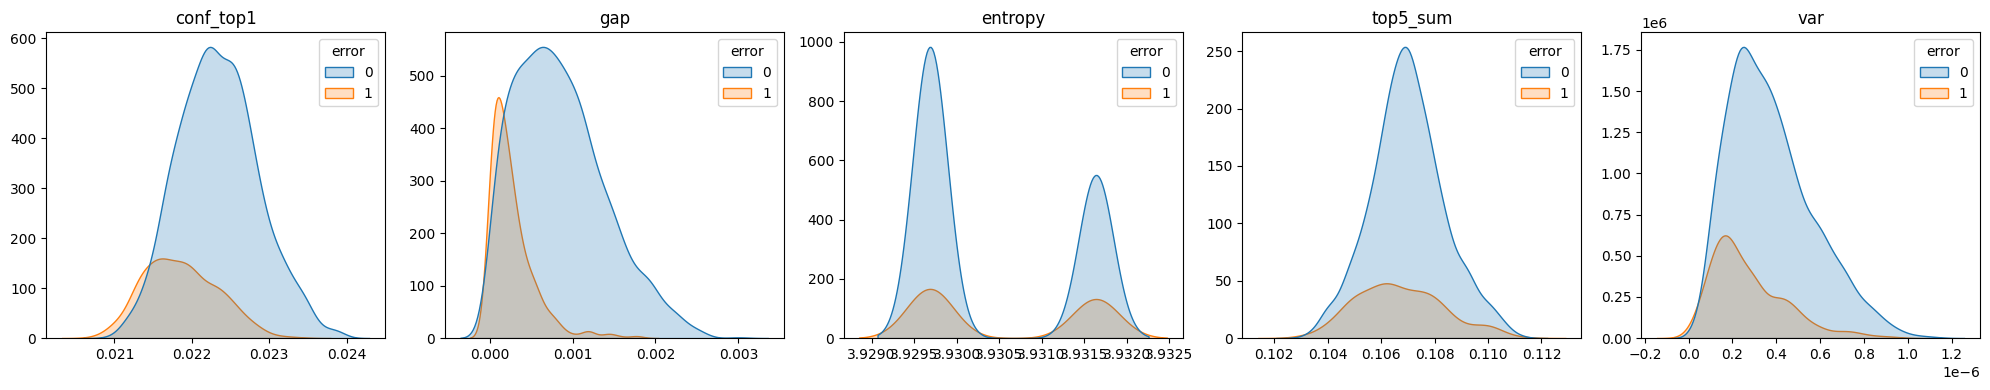

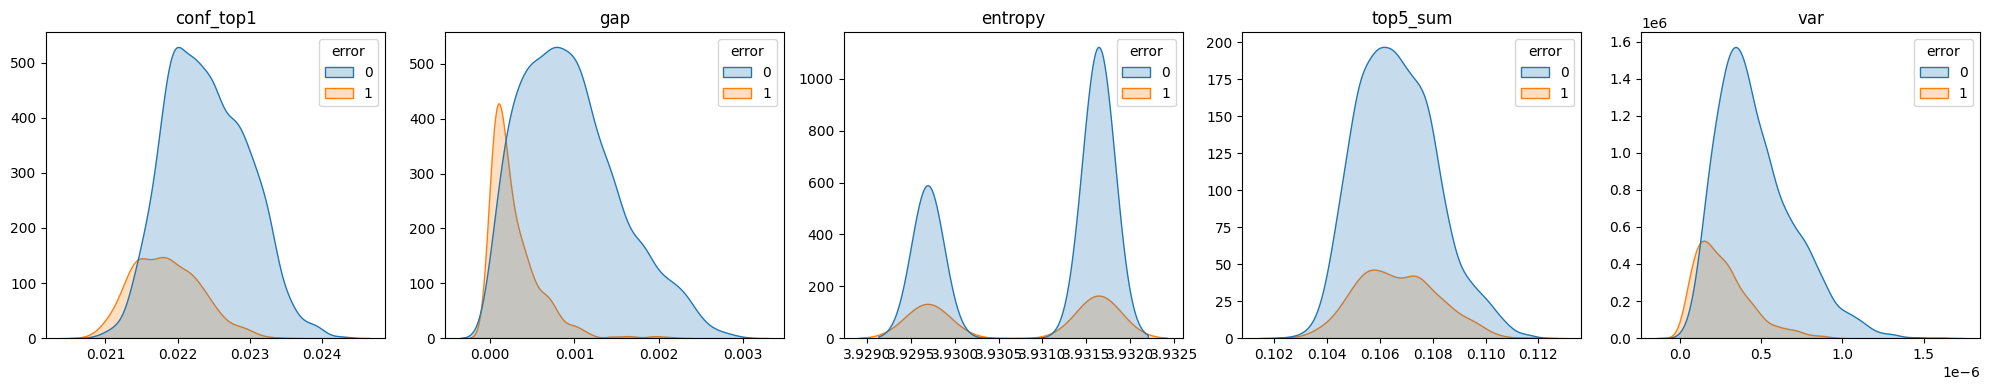

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(X_test_base, columns=["conf_top1", "gap", "entropy", "top5_sum", "var"])
df["error"] = y_test_base

features = ["conf_top1", "gap", "entropy", "top5_sum", "var"]

# Crea una riga di subplot (5 colonne, 1 riga)
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(20, 4))  # Larghezza = 4x num feature

for ax, feat in zip(axes, features):
    sns.kdeplot(data=df, x=feat, hue="error", fill=True, ax=ax)
    ax.set_title(f"{feat}")
    ax.set_xlabel("")
    ax.set_ylabel("")

# Riduci spazi tra subplot
plt.tight_layout()
plt.show()


df = pd.DataFrame(X_test_novel, columns=["conf_top1", "gap", "entropy", "top5_sum", "var"])
df["error"] = y_test_novel

# Crea una riga di subplot (5 colonne, 1 riga)
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(20, 4))  # Larghezza = 4x num feature

for ax, feat in zip(axes, features):
    sns.kdeplot(data=df, x=feat, hue="error", fill=True, ax=ax)
    ax.set_title(f"{feat}")
    ax.set_xlabel("")
    ax.set_ylabel("")

# Riduci spazi tra subplot
plt.tight_layout()
plt.show()

🔍 Evaluating Uncertainty Classifier
📊 Generating predictions...
📈 Computing performance metrics...

📋 PERFORMANCE SUMMARY
----------------------------------------
📈 Training Set:
   • Accuracy:  0.8216 (82.2%)
   • Precision: 0.5942 (59.4%)
   • Recall:    0.7625 (76.2%)
   • F1-Score:  0.6679
   • AUC-ROC:   0.9048
🧪 Test Set:
   • Accuracy:  0.7784 (77.8%)
   • Precision: 0.4779 (47.8%)
   • Recall:    0.6932 (69.3%)
   • F1-Score:  0.5658
   • AUC-ROC:   0.8412

🔍 OVERFITTING ANALYSIS:
   • Accuracy gap: 0.0432 (✅ Low)
   • AUC gap:      0.0637 (✅ Low)

📊 CLASS DISTRIBUTION:
   • Training: Correct=780, Uncorrect=240 (Ratio: 0.24)
   • Test:     Correct=1958, Uncorrect=515 (Ratio: 0.21)

🎨 Generating visualizations...


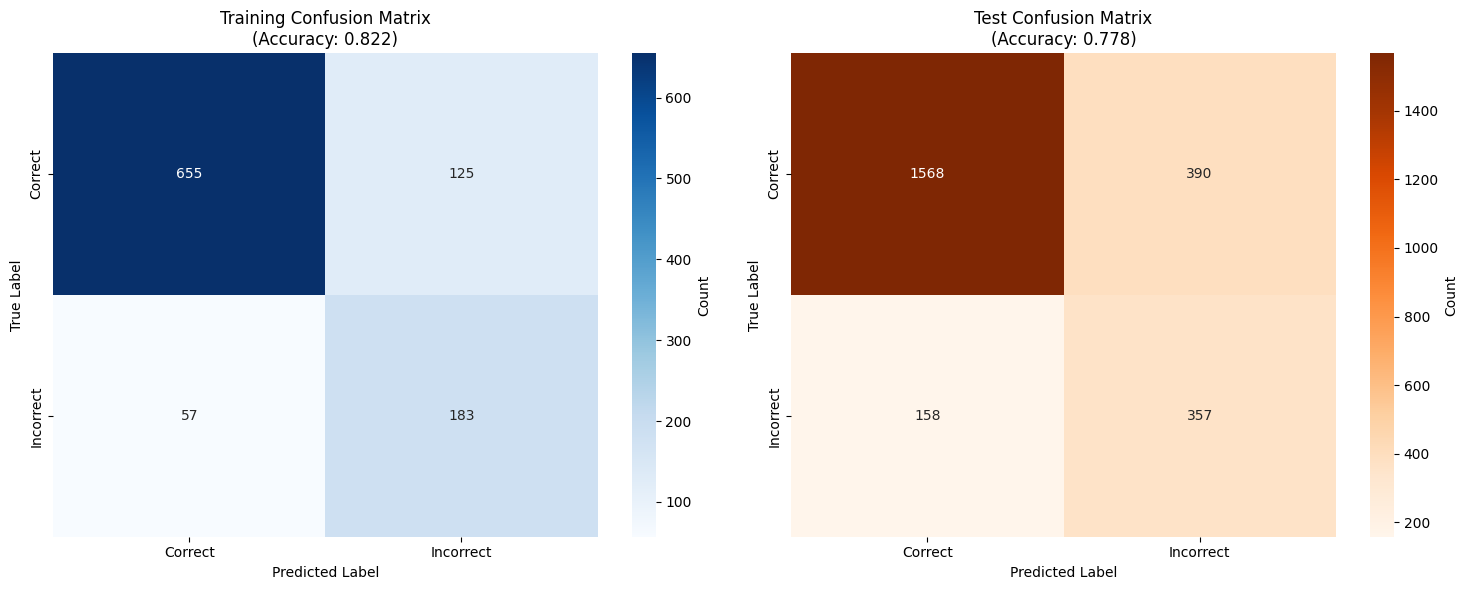

✅ Evaluation completed!
🔍 Evaluating Uncertainty Classifier
📊 Generating predictions...
📈 Computing performance metrics...

📋 PERFORMANCE SUMMARY
----------------------------------------
📈 Training Set:
   • Accuracy:  0.8216 (82.2%)
   • Precision: 0.5942 (59.4%)
   • Recall:    0.7625 (76.2%)
   • F1-Score:  0.6679
   • AUC-ROC:   0.9048
🧪 Test Set:
   • Accuracy:  0.8232 (82.3%)
   • Precision: 0.5338 (53.4%)
   • Recall:    0.6985 (69.8%)
   • F1-Score:  0.6051
   • AUC-ROC:   0.8517

🔍 OVERFITTING ANALYSIS:
   • Accuracy gap: -0.0016 (✅ Low)
   • AUC gap:      0.0531 (✅ Low)

📊 CLASS DISTRIBUTION:
   • Training: Correct=780, Uncorrect=240 (Ratio: 0.24)
   • Test:     Correct=2963, Uncorrect=713 (Ratio: 0.19)

🎨 Generating visualizations...


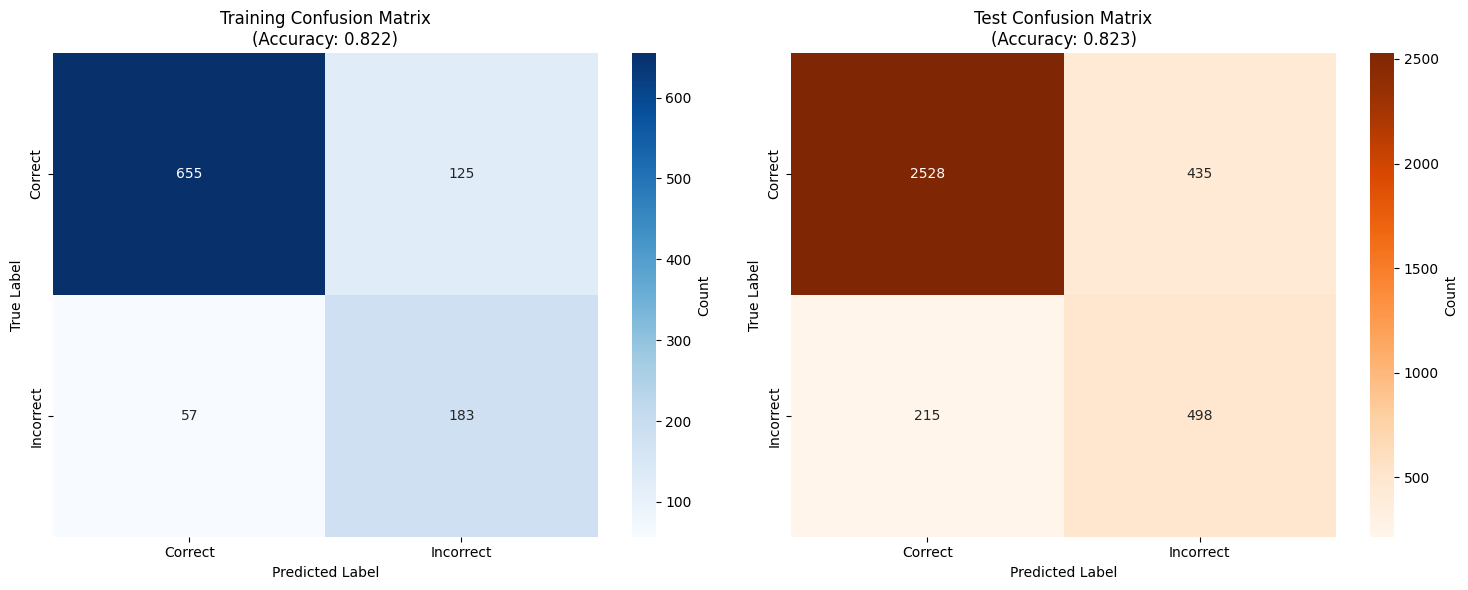

✅ Evaluation completed!


In [ ]:
results_base= evaluate_uncertainty_model(clf, X, y, X_test_base, y_test_base, threshold= 0.3)
results_novel = evaluate_uncertainty_model(clf, X, y, X_test_novel, y_test_novel, threshold= 0.3)